# Task 2: Sentiment and Thematic Analysis

This notebook quantifies review sentiment and identifies themes to uncover satisfaction drivers and pain points for three Ethiopian banks, as per project requirements.

In [1]:
import pandas as pd
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# Load the cleaned reviews from Task 1
input_path = '../data/bank_reviews_cleaned.csv'
assert os.path.exists(input_path), f'Input file not found: {input_path}'
df = pd.read_csv(input_path)
df = df.reset_index(drop=True)
df['review_id'] = df.index + 1  # Add review_id as required
df.head()

,review,rating,date,bank,source,review_id
0,really am happy to this app it is Siple to use...,5,2025-06-07,Commercial Bank of Ethiopia,Google Play,1
1,I liked this app. But the User interface is ve...,2,2025-06-07,Commercial Bank of Ethiopia,Google Play,2
2,"""Why don’t your ATMs support account-to-accoun...",4,2025-06-06,Commercial Bank of Ethiopia,Google Play,3
3,what is this app problem???,1,2025-06-05,Commercial Bank of Ethiopia,Google Play,4
4,the app is proactive and a good connections.,5,2025-06-05,Commercial Bank of Ethiopia,Google Play,5


In [12]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
reviews = df['review_text'].astype(str).tolist()
sentiments = []
batch_size = 64
for i in range(0, len(reviews), batch_size):
    batch = reviews[i:i+batch_size]
    sentiments.extend(sentiment_pipeline(batch, truncation=True))

def signed_score(sentiment):
    if sentiment['label'] == 'POSITIVE':
        return sentiment['score']
    elif sentiment['label'] == 'NEGATIVE':
        return -sentiment['score']
    else:
        return 0

df['sentiment_label'] = [s['label'] for s in sentiments]
df['sentiment_score'] = [signed_score(s) for s in sentiments]

Device set to use cpu


KeyError: 'review_text'

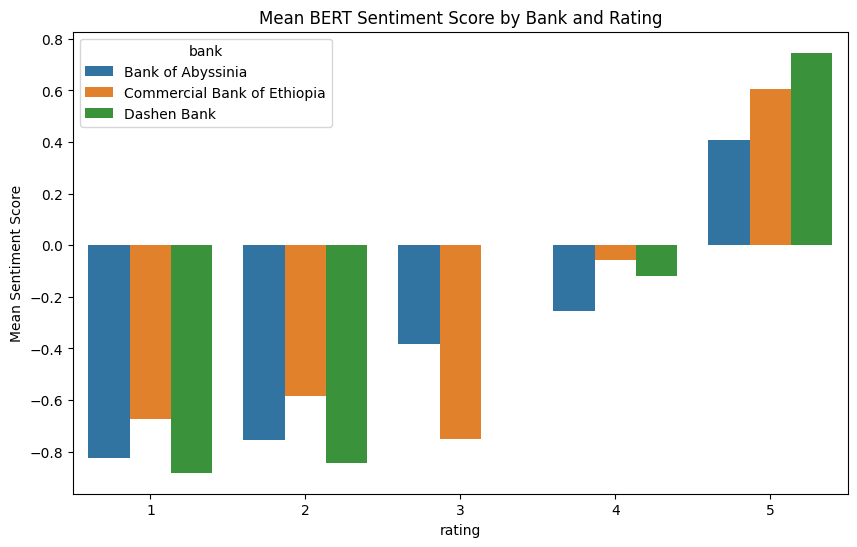

In [11]:
# Aggregate mean sentiment score by bank and rating (using BERT)
agg = df.groupby(['bank', 'rating'])['bert_sentiment_score'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=agg, x='rating', y='bert_sentiment_score', hue='bank')
plt.title('Mean BERT Sentiment Score by Bank and Rating')
plt.ylabel('Mean Sentiment Score')
plt.show()